# LoFi v.s. subspaceEKF

In [1108]:
import jax
import einops
import numpy as np
import jax.numpy as jnp
import flax.linen as nn
from typing import Callable
from rebayes.extended_kalman_filter import ekf
from rebayes.low_rank_filter.subspace_filter import subcify
from rebayes.low_rank_filter import lofi
from rebayes.datasets.datasets import load_mnist

In [1109]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1205]:
res = load_mnist()
res = jax.tree_map(jnp.array, res)
(X_train, y_train), (X_test, y_test) = res
X_train = einops.rearrange(X_train, "obs width height -> obs (width height)")
X_test = einops.rearrange(X_test, "obs width height -> obs (width height)")

y_train_ohe = jax.nn.one_hot(y_train, 10)
y_test_ohe = jax.nn.one_hot(y_test, 10)

In [1206]:
class NNet(nn.Module):
    activation: Callable = nn.elu
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(500)(x)
        x = self.activation(x)
        x = nn.Dense(300)(x)
        x = self.activation(x)
        x = nn.Dense(300)(x)
        x = self.activation(x)
        x = nn.Dense(100)(x)
        x = self.activation(x)
        x = nn.Dense(10)(x)
        x = nn.softmax(x)
        return x

In [1207]:
key = jax.random.PRNGKey(314)
model = NNet()
params_init = model.init(key, X_train[:10])
params_init_flat, _ = ravel_pytree(params_init)

## LoFi agent

In [1208]:
def callback(bel, pred_obs, t, Xt, Yt, bel_pred, **kwargs):    
    # eval on all tasks test set
    yhat = agent.emission_mean_function(bel.mean, X_test).argmax(axis=1)
    acc = jnp.mean(yhat == y_test)
    
    out = {
        "acc": acc
    }
    
    return out

In [1209]:
agent, recfn = lofi.init_classification_agent(
    model,
    X_train[:10],
    dynamics_weights=1.0,
    dynamics_covariance=1e-6,
    memory_size=20,
)

In [1238]:
%%time
bel, outputs = agent.scan(
    initial_mean=params_init_flat,
    initial_covariance=1e-2,#1e-7,
    X=X_train[:1000],
    Y=y_train_ohe[:1000],
    progress_bar=False,
    callback=callback,
)

bel = jax.block_until_ready(bel)
outputs = jax.tree_map(np.array, outputs)
acc_lofi = outputs["acc"]

CPU times: user 1min 14s, sys: 1.72 s, total: 1min 16s
Wall time: 30.3 s


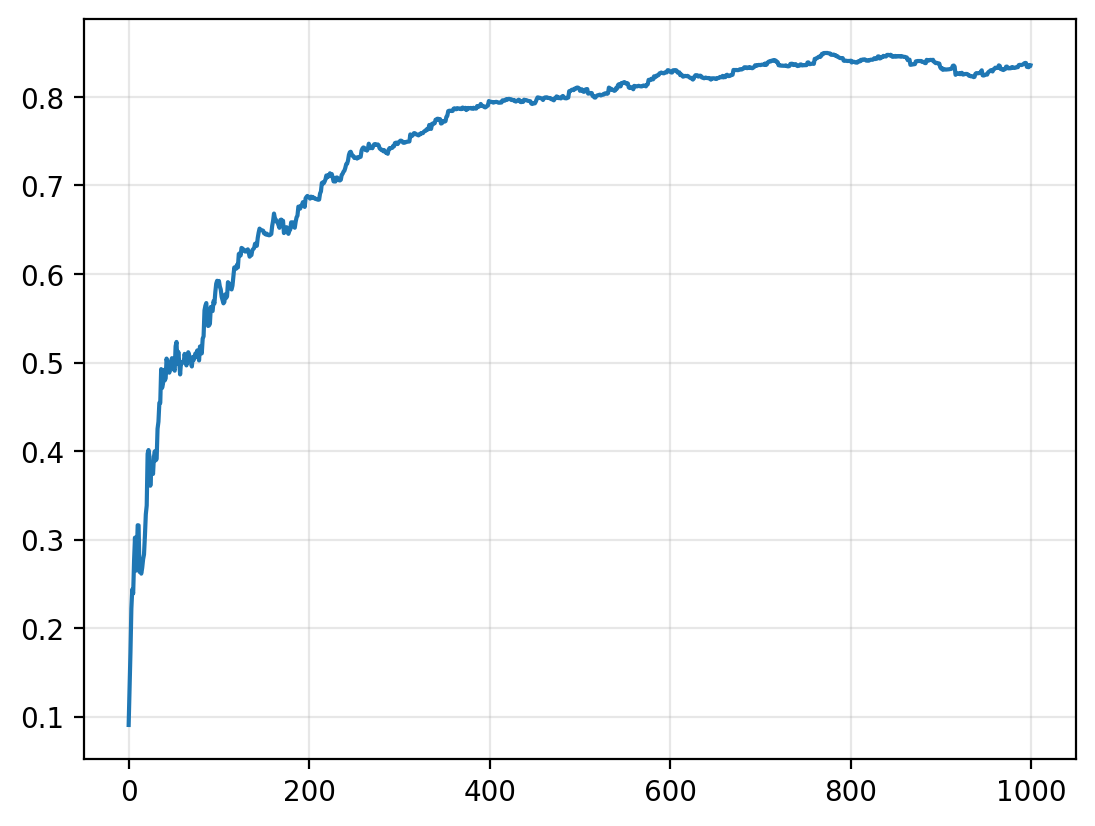

In [1239]:
plt.plot(acc_lofi)
plt.grid(alpha=0.3)

In [1240]:
agent.predict_obs(bel, X_test).argmax(axis=1)

Array([7, 6, 1, ..., 4, 5, 6], dtype=int32)

In [1241]:
yhat_test = agent.predict_obs(bel, X_test).argmax(axis=1)
(yhat_test == y_test).mean()

Array(0.8358, dtype=float32)

## Subspace agent

In [1314]:
SubNNet = subcify(NNet)
dim_in = 28 ** 2

dim_subspace = 20
model_sub = SubNNet(dim_in, dim_subspace=dim_subspace)

params_init = model_sub.init(key, X_train[:10])
params_init_flat, _ = ravel_pytree(params_init)

In [1315]:
P = params_init["fixed"]["P"]
P = P / jnp.linalg.norm(P, axis=0) * 10

params_init["fixed"]["P"] = P

In [1316]:
pfixed, psubspace_init = params_init["fixed"], params_init["params"]
psubspace_init_flat, recfn = ravel_pytree(psubspace_init)

In [1317]:
def applyfn(psubspace, X):
    pfull = {
        "fixed": pfixed,
        "params": psubspace
    }
    return model_sub.apply(pfull, X)

In [1318]:
dynamics_weights=1.0
dynamics_covariance=1e-6
method="fcekf"

def apply_fn(flat_params, x):
    return applyfn(recfn(flat_params), x)

def emission_cov_fn(flat_params, x, eps=1e-6):
    p = apply_fn(flat_params, x).ravel()
    return jnp.diag(p) - jnp.outer(p, p) + eps * jnp.eye(len(p))

agent = ekf.RebayesEKF(
    dynamics_weights_or_function=dynamics_weights,
    dynamics_covariance=dynamics_covariance,
    emission_mean_function=apply_fn,
    emission_cov_function=emission_cov_fn,
    adaptive_emission_cov=False,
    emission_dist=lambda mean, cov: tfd.Categorical(probs=mean),
    method=method,
)

In [1319]:
key_new = jax.random.PRNGKey(271)
# psubspace_init_flat = jax.random.normal(key, ) * 2
psubspace_init_flat = jax.random.uniform(key_new, (dim_subspace,), minval=-1, maxval=1)

In [1321]:
%%time
bel, outputs = agent.scan(
    initial_mean=psubspace_init_flat,
    initial_covariance=1.0,
    X=X_train[:1000],
    Y=y_train_ohe[:1000],
    progress_bar=False,
    callback=callback
)

bel = jax.block_until_ready(bel)
outputs = jax.tree_map(np.array, outputs)
acc_subekf = outputs["acc"]

CPU times: user 38.5 s, sys: 377 ms, total: 38.9 s
Wall time: 21.4 s


Array(0.3304, dtype=float32)

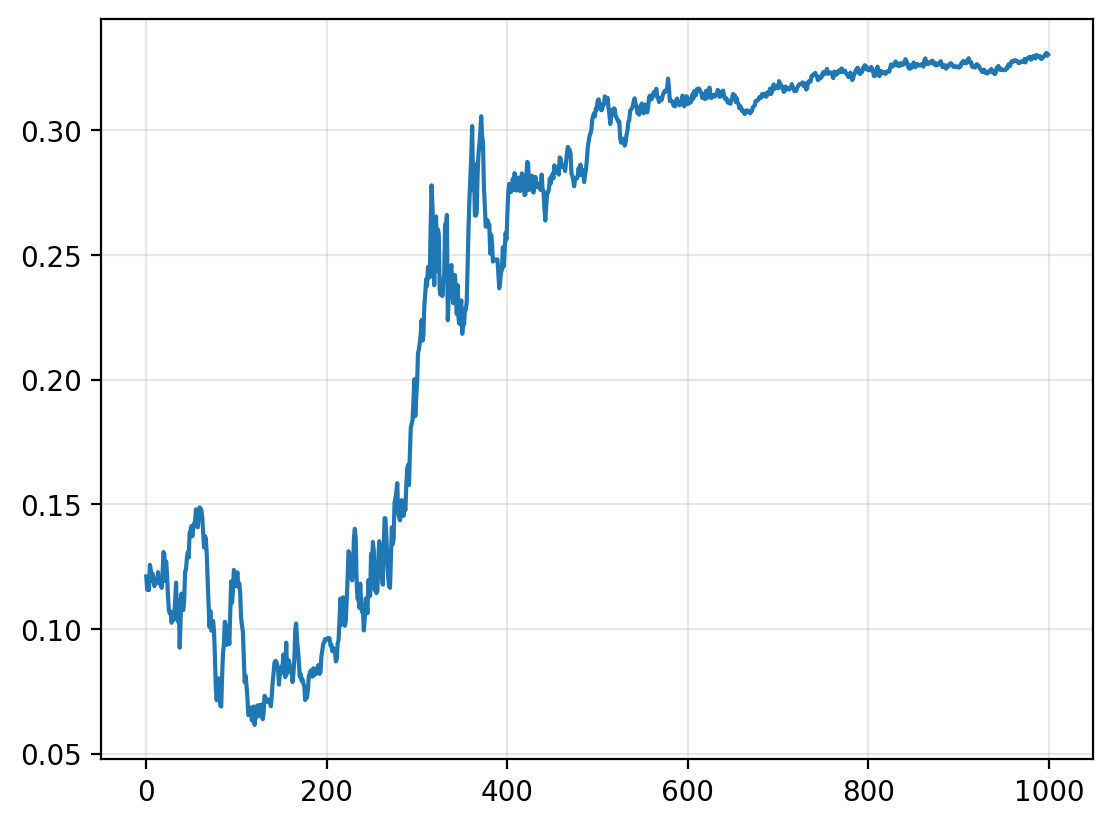

In [1322]:
plt.plot(acc_subekf)
plt.grid(alpha=0.3)

yhat_test = apply_fn(bel.mean, X_test).argmax(axis=1)
(yhat_test == y_test).mean()

## Comparisson

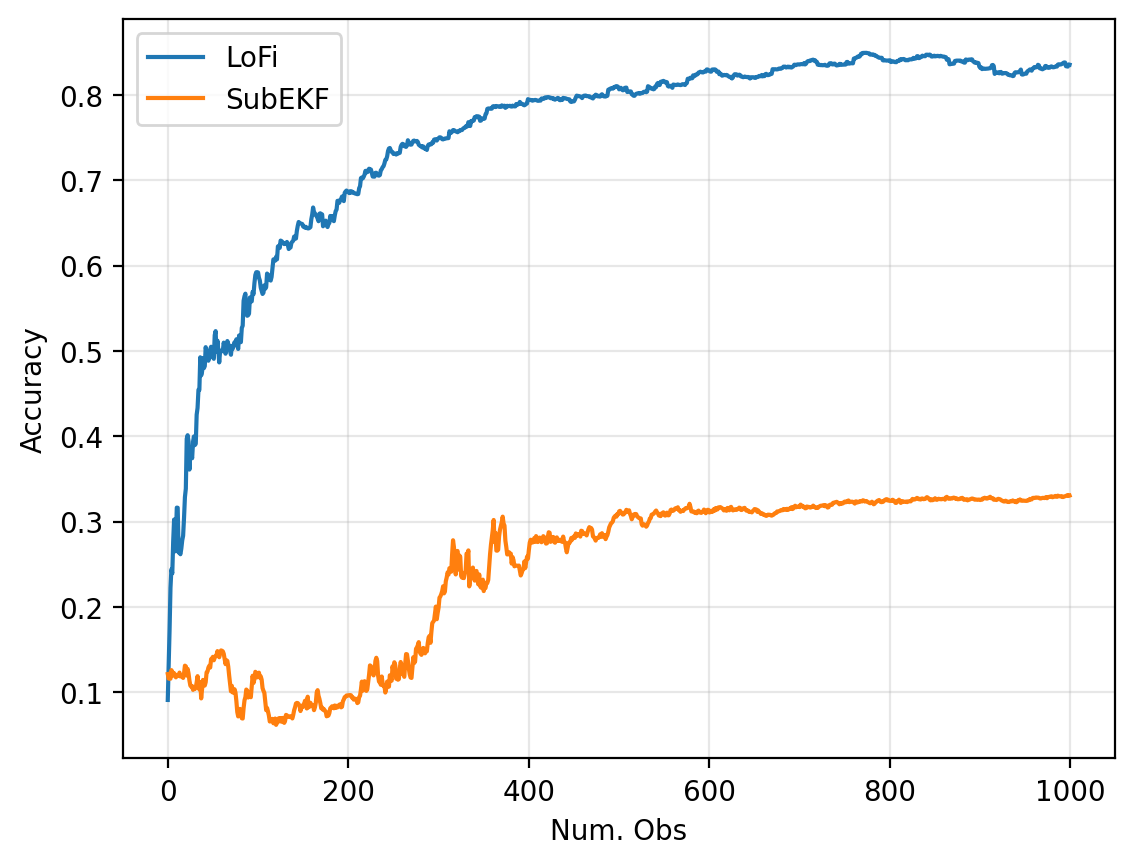

In [1323]:
plt.plot(acc_lofi, label="LoFi")
plt.plot(acc_subekf, label="SubEKF")
plt.legend()
plt.xlabel("Num. Obs")
plt.ylabel("Accuracy")
plt.grid(alpha=0.3)